# Setup

In [2]:
from mobilkit.umni import *
from project import *

# Compare with AAA

## Load AAA

In [3]:
def get_aaa(scale, mode, max_tt, col='w_c000', acs=acs, zones=zones):
    df = pd.read_parquet(f'../data/aaa/{mode.lower()}/{max_tt:02}_min.parquet')
    df = df[col].rename('value').reset_index().astype({'geoid': str})
    nchar = {'BG': 12, 'TRACT': 11, 'COUNTY': 5}[scale]
    popu = (acs.assign(geoid=acs.geoid.str[:nchar])
            .groupby('geoid')['popu'].sum().reset_index())
    df = (df.assign(geoid=df.geoid.str[:nchar])
          .groupby('geoid')['value'].sum().reset_index())
    df = df.merge(popu, on='geoid')
    df['value_per_person'] = df.value / df.popu
    df = zones[['geoid', 'geometry']].merge(df, on='geoid')
    return df

aaa = get_aaa(scale='TRACT', mode='TRANSIT', max_tt=60).disp()

NameError: name 'acs' is not defined

In [ ]:
# zones.query('scale=="COUNTY"').explore()

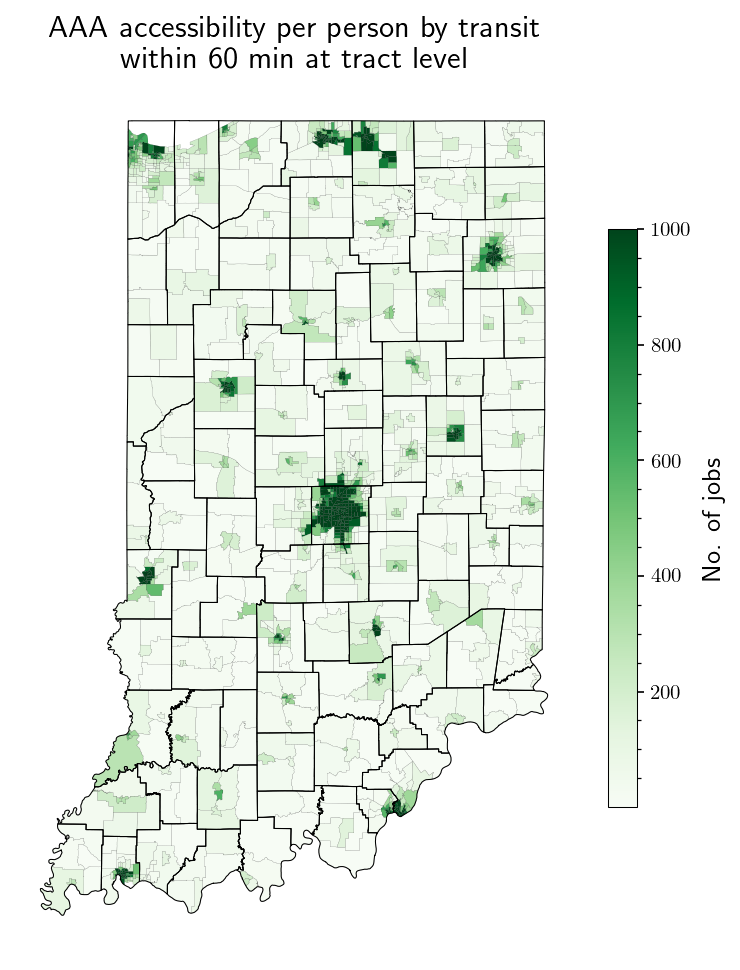

In [ ]:
title = 'AAA accessibility per person by transit\nwithin 60 min at tract level'
ax = U.plot(size=(6, 10), axoff=1, title=title)
aaa.plot(ax=ax, column='value_per_person', cmap='Greens',
         legend=True, vmax=1e3, ec='k', lw=0.05,
         legend_kwds=dict(shrink=0.5, label='No. of jobs'))
zones.query('scale=="COUNTY"').plot(ax=ax, fc='none', ec='k', lw=0.5);

## LODES data

In [6]:
df = pd.read_parquet('../data/lodes/od.parquet'); df

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03
0,180010301001017,180010301001054,1,0,0,1,1,0,0,0,0,1
1,180010301001017,180010301004041,1,0,0,1,0,1,0,0,0,1
2,180010301001017,180010302001003,1,0,1,0,1,0,0,1,0,0
3,180010301001017,180010302003056,1,0,1,0,0,1,0,1,0,0
4,180010301001017,180010303001003,1,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2574934,181830507003040,180030023003002,1,0,0,1,0,1,0,0,1,0
2574935,181830507003040,180030102012019,1,0,0,1,0,0,1,0,1,0
2574936,181830507003040,180030119002029,1,0,0,1,1,0,0,0,1,0
2574937,181830507003040,180859615003001,1,1,0,0,0,1,0,0,1,0


In [4]:
def get_lodes_od(scale, col='S000'):
    df = pd.read_parquet('../data/lodes/od.parquet')
    nchar = {'BG': 12, 'TRACT': 11, 'COUNTY': 5}[scale]
    df['source'] = df['h_geocode'].astype(str).str[:nchar]
    df['target'] = df['w_geocode'].astype(str).str[:nchar]
    df = df.groupby(['source', 'target'])[col].sum().rename('njobs').reset_index()
    return df

od = get_lodes_od('TRACT').disp()

470,203 rows x 3 cols; Memory: 64.6 MiB


,source,target,njobs
,<object>,<object>,<int64>
0,18001030100,18001030100,209


## Travel times

In [ ]:
tt_tract = (get_tt('TRACT').query('time <= 60 & mode == "TRANSIT"')
            .drop(columns='mode').reset_index(drop=True)).disp()

  0%|          | 0/4 [00:00<?, ?it/s]

20,909 rows x 3 cols; Memory: 2.9 MiB


,source,target,time
,<object>,<object>,<float64>
0,18105001304,18105001301,54.466667


## AAA-type accessibility

In [ ]:
popu = (acs.assign(geoid=acs.geoid.str[:11]).groupby('geoid')['popu'].sum().reset_index()).disp()

1,505 rows x 2 cols; Memory: 0.1 MiB


,geoid,popu
,<object>,<float64>
0,18001030100,4593.0


In [ ]:
xs = (od.merge(tt_tract, on=('source', 'target')).groupby('source')
      ['njobs'].sum().rename_axis('geoid').reset_index().merge(popu, on='geoid')
      .assign(njobs_per_person=lambda df: df.njobs / df.popu))
xs = zones[['geoid', 'geometry']].merge(xs, on='geoid').disp()

947 rows x 5 cols; Memory: 0.1 MiB; CRS: EPSG:4326


,geoid,geometry,njobs,popu,njobs_per_person
,<object>,<geometry>,<int64>,<float64>,<float64>
0,18105001301,"POLYGON ((-86.573543 39.164567, -86.573657 39....",90,5446.0,0.016526


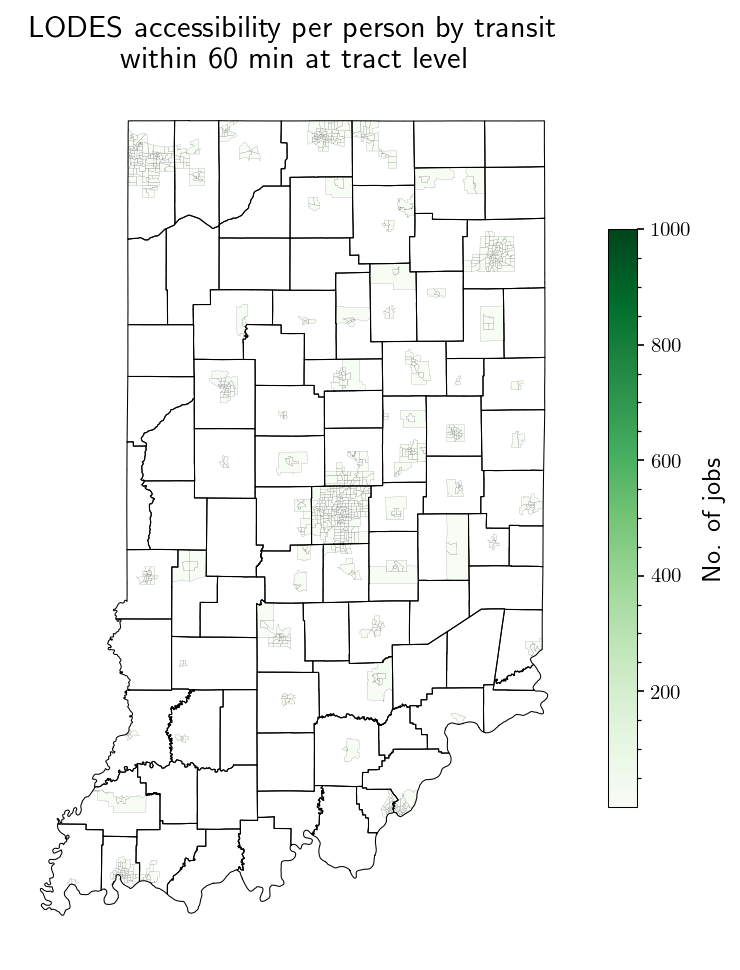

In [ ]:
title = 'LODES accessibility per person by transit\nwithin 60 min at tract level'
ax = U.plot(size=(6, 10), axoff=1, title=title)
xs.plot(ax=ax, column='njobs_per_person', cmap='Greens',
        legend=True, vmax=1e3, ec='k', lw=0.05,
        legend_kwds=dict(shrink=0.5, label='No. of jobs'))
zones.query('scale=="COUNTY"').plot(ax=ax, fc='none', ec='k', lw=0.5);